### 데이터 분리

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

data = fetch_california_housing()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


In [114]:
## 파이토치 패키지 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [115]:
data = torch.from_numpy(df.values).float()
print(data[0])

X = data[:, :-1]
y = data[:, -1].reshape(-1, 1)

print(f'X Shape : {X.shape}\ny Shape : {y.shape}')

tensor([   8.3252,   41.0000,    6.9841,    1.0238,  322.0000,    2.5556,
          37.8800, -122.2300,    4.5260])
X Shape : torch.Size([20640, 8])
y Shape : torch.Size([20640, 1])


In [116]:
ratios = [.6, .2, .2]   ## 6 : 2 : 2

train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = int(data.size(0) * ratios[2])

cnts = [train_cnt, valid_cnt, test_cnt]

print(f'Train {cnts[0]} / Valid {cnts[1]} / Test {cnts[2]}')

Train 12384 / Valid 4128 / Test 4128


In [117]:
## 데이터 shuffle -> split

indices = torch.randperm(data.size(0))

X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

labels = ['Train', 'Valid', 'Test']
X = list(X.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

for l_i, x_i, y_i in zip(labels, X, y):
    print(l_i, x_i.size(), y_i.size())

Train torch.Size([12384, 8]) torch.Size([12384, 1])
Valid torch.Size([4128, 8]) torch.Size([4128, 1])
Test torch.Size([4128, 8]) torch.Size([4128, 1])


In [118]:
# Standard Scailing

scaler = StandardScaler()

X[0] = torch.from_numpy(scaler.fit_transform(X[0].numpy())).float()
X[1] = torch.from_numpy(scaler.transform(X[1].numpy())).float()
X[2] = torch.from_numpy(scaler.transform(X[2].numpy())).float()


In [119]:
X[0].shape

torch.Size([12384, 8])

In [120]:
# 모델 구현

model = nn.Sequential(
    nn.Linear(X[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

print(model)
optimizer = optim.Adam(model.parameters())

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [121]:
# 학습 파라미터 설정

n_epochs = 4000
batch_size = 128
print_interval = 400



In [122]:
from copy import deepcopy

lowest_loss = np.inf  # Eposh 최저 손실 저장
best_model = None     # Best moddel 저장 (손실 가장 적은)

early_stop = 100
loweest_epoch = np.inf # early_stopping을 위한 에포크 저장

In [123]:
X[0].size()

torch.Size([12384, 8])

In [124]:
train_history, valid_history = [], []

for i in range(n_epochs):
    # 데이터 섞고 mini-batch 데이터 구성
    indices = torch.randperm(X[0].size(0))
    x_ = torch.index_select(X[0], dim=0, index=indices) # |x_| => (total_size, input_dim)
    y_ = torch.index_select(y[0], dim=0, index=indices) # |y_| => (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0) # |x_[i]| => (batch_size, input_dim)
    y_ = y_.split(batch_size, dim=0) # |y_[i]| => (batch_size, output_dim)

    
    train_loss, valid_loss = 0, 0  # train/valid Loss 저장
    y_hat = []             
    
    for x_i, y_i in zip(x_, y_):

        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    # Validation 할떄는 gradient 계산 X
    with torch.no_grad():

        x_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    # loss 값들 history 저장
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        # 베스트모델 저장
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)

Epoch 400: train loss=3.2385e-01  valid_loss=3.1608e-01  lowest_loss=3.1592e-01
Epoch 800: train loss=3.1061e-01  valid_loss=3.0568e-01  lowest_loss=3.0395e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 741: 3.0395e-01


<All keys matched successfully>

In [127]:
lowest_epoch+1

741

In [133]:
lowest_epoch

740

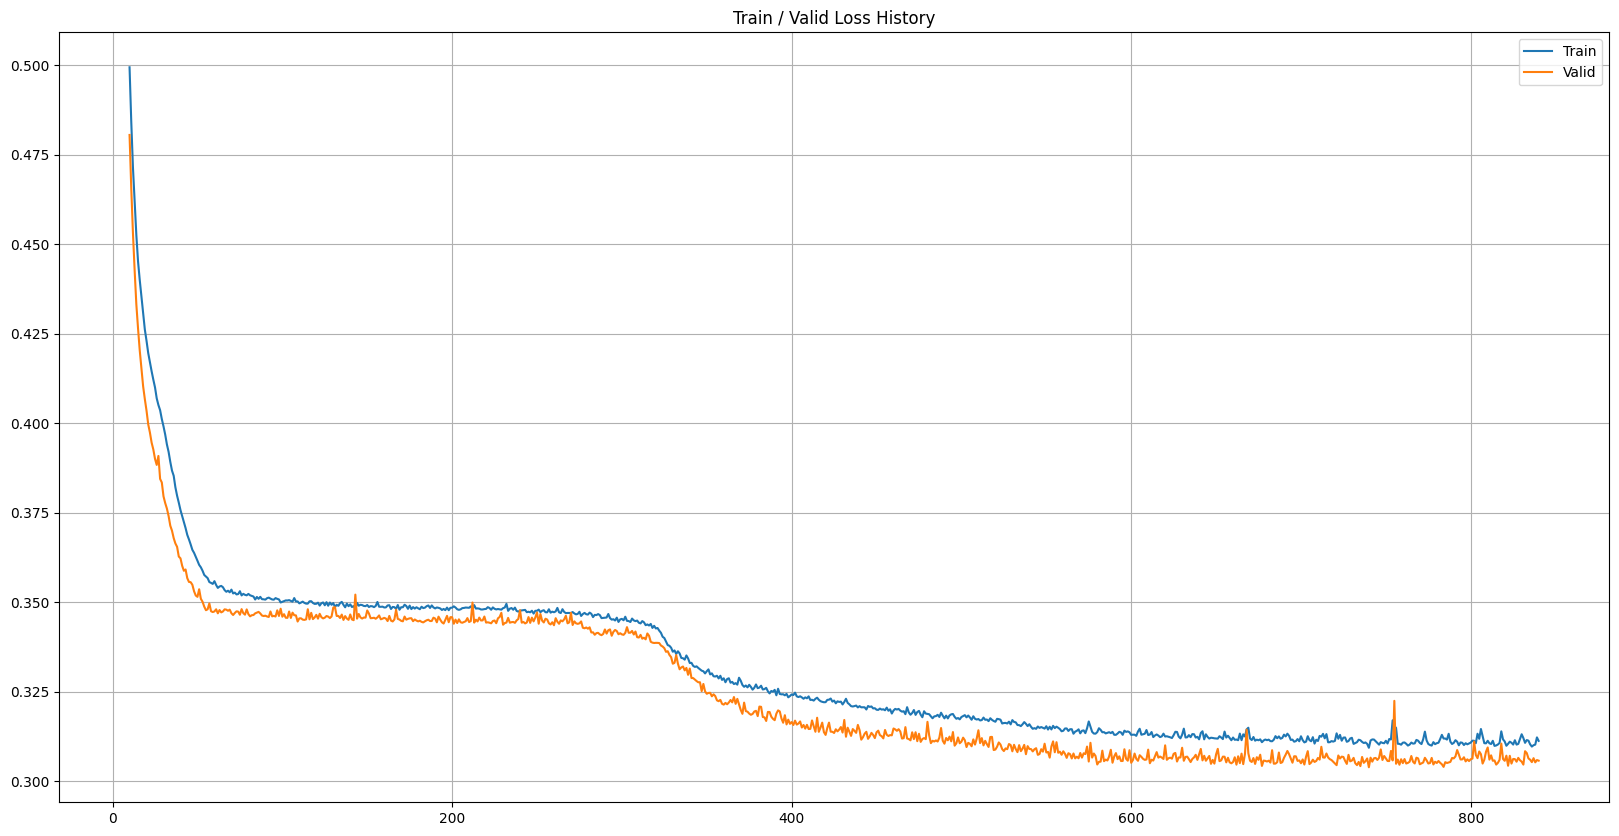

In [150]:
plot_from = 10


plt.figure(figsize=(20, 10))

plt.plot(range(plot_from, len(train_history)), train_history[plot_from:],
        range(plot_from, len(valid_history)), valid_history[plot_from:],)
# plt.vlines(loweest_epoch+1, 0.0, 0.5, linewidth=12, color='lightgray', linestyle='--')

plt.title('Train / Valid Loss History')
plt.legend(['Train', 'Valid'])
plt.grid(True)
plt.show()

In [159]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss
        y_hat = [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key = lambda x: x[1])
print('Train Loss : %.4e' % sorted_history[0][0])
print('Valid Loss : %.4e' % sorted_history[1][0])
print('Test Loss : %.4e' % test_loss)

Train Loss : 3.0939e-01
Valid Loss : 3.1198e-01
Test Loss : 3.1141e-01
